In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
import torch
import torch.optim as optim
from torch.nn import BCELoss
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter, Module, LeakyReLU
import matplotlib.pyplot as plt
from sklearn import preprocessing
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

file = '../data/data.csv'
df = pd.read_csv(file)
df = df.drop(columns=['elapsed_time'])

type_var = ['match_id', 'player1', 'player2']
num_var = ['set_no', 'game_no',
            'point_no', 'p1_sets', 'p2_sets', 'p1_games', 'p2_games',
            'server', 'p1_net_pt', 'p2_net_pt', 'p1_break_pt', 'p2_break_pt',
            'p1_distance_run','p2_distance_run', 'rally_count']

for var in type_var:
    le = preprocessing.LabelEncoder()
    le.fit(df[var])
    df.loc[:, var] = le.transform(df[var])

df.loc[df['point_victor'] == 2, 'point_victor'] = 0

scaler = MinMaxScaler()
df[num_var+type_var] = scaler.fit_transform(df[num_var+type_var])

grouped_data = df.groupby(['match_id'])

In [2]:
class CLG(nn.Module):
    def __init__(self):
        super(CLG, self).__init__()
        self.scale = 8
        self.conv = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.fft_layer = GlobalFourierTransformEncoder()
        self.lstm = nn.LSTM(input_size=16, hidden_size=8, num_layers=2, batch_first=True)
        self.fc = nn.Linear(8, 1)
    
    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.leaky_relu(self.conv(x))
        x = self.fft_layer(x)
        x = x.transpose(1, 2)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = torch.sigmoid(self.fc(x))
        mean_x = torch.mean(x, dim=0, keepdim=True) 
        x = (x - mean_x) * self.scale + mean_x
        return x

class GlobalFourierTransformEncoder(nn.Module):
    def __init__(self):
        super(GlobalFourierTransformEncoder, self).__init__()
    
    def forward(self, x):
        x_fft = torch.fft.rfft(x, dim=2)
        x_fft_abs = torch.sqrt(torch.real(x_fft)**2 + torch.imag(x_fft)**2)
        return x_fft_abs

In [3]:
class CGA(nn.Module):
    def __init__(self):
        super(CGA, self).__init__()
        
        self.conv = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        nn.init.kaiming_normal_(self.conv.weight, mode='fan_out', nonlinearity='relu')
        self.gru = nn.GRU(input_size=16, hidden_size=8, num_layers=1, batch_first=True, bidirectional=True)
        self.attention = nn.Sequential(
            nn.Linear(8 * 2, 16),
            nn.Tanh(),
            nn.Linear(16, 1),
            nn.Softmax(dim=1)
        )
        self.batch_norm = nn.BatchNorm1d(8 * 2)
        self.output_layer = nn.Linear(8 * 2, 1)

        nn.init.xavier_normal_(self.output_layer.weight)
        self.output_layer.bias.data.fill_(0.1)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = x.transpose(1, 2)
        x, _ = self.gru(x)
        
        # 应用注意力机制到所有时间步
        attention_weights = self.attention(x).squeeze(-1)
        x_attention = torch.sum(x * attention_weights.unsqueeze(-1), dim=1)
        
        # 条件性应用Batch Normalization
        if x_attention.size(0) > 1:  # 如果批量大小大于1
            x_attention = self.batch_norm(x_attention)
        
        output = self.output_layer(x_attention)
        output = output.squeeze(dim=1)
        probability = torch.sigmoid(output)
        return probability, attention_weights

In [4]:
class WeightedBCELoss(nn.Module):
    def __init__(self, weight):
        super(WeightedBCELoss, self).__init__()
        self.weight = weight
    
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        weighted_bce_loss = bce_loss * self.weight
        loss = torch.mean(weighted_bce_loss)
        return loss

In [5]:
def train_CLG():
    for match_id, group_data in grouped_data:
        # 创建子集数据
        subset_X = torch.tensor(group_data[num_var + type_var].values.astype(np.float32))
        subset_y = torch.tensor(group_data['point_victor'].values.astype(np.float32))
        subset_dataset = TensorDataset(subset_X, subset_y)
        subset_dataloader = DataLoader(subset_dataset, batch_size=32, shuffle=False)

        weight = torch.tensor([2.0])
        
        # 创建子集模型
        subset_model = CLG()
        subset_criterion =  WeightedBCELoss(weight)
        subset_optimizer = optim.Adam(subset_model.parameters(), lr=0.001)
        
        # 训练子集模型
        num_epochs = 5
        for epoch in range(num_epochs):
            for inputs, labels in subset_dataloader:
                outputs = subset_model(inputs)
                labels = labels.unsqueeze(1)
                loss = subset_criterion(outputs, labels)
                subset_optimizer.zero_grad()
                loss.backward()
                subset_optimizer.step()
        
        # 获取子集模型的输出概率
        with torch.no_grad():
            subset_probabilities = subset_model(subset_X).squeeze().numpy()
        
        # 将子集的输出概率添加到原始表格中的相应位置
        df.loc[df['match_id'] == match_id, 'pred_clg'] = subset_probabilities

In [6]:
def train_CGA():
    for match_id, group_data in grouped_data:
        # 创建子集数据
        subset_X = torch.tensor(group_data[num_var + type_var].values.astype(np.float32))
        subset_y = torch.tensor(group_data['point_victor'].values.astype(np.float32))
        subset_dataset = TensorDataset(subset_X, subset_y)
        subset_dataloader = DataLoader(subset_dataset, batch_size=32, shuffle=True)
        
        weight = torch.tensor([2.0])
        
        subset_model = CGA()
        subset_criterion = WeightedBCELoss(weight)
        subset_optimizer = optim.Adam(subset_model.parameters(), lr=0.01)
        
        # 训练子集模型
        num_epochs = 5
        for epoch in range(num_epochs):
            for inputs, labels in subset_dataloader:
                outputs, _ = subset_model(inputs)
                loss = subset_criterion(outputs, labels)
                subset_optimizer.zero_grad()
                loss.backward()
                subset_optimizer.step()
        
        # 获取子集模型的输出概率
        with torch.no_grad():
            outputs, _ = subset_model(subset_X)
            subset_probabilities = outputs.squeeze().numpy()
        
        # 将子集的输出概率添加到原始表格中的相应位置
        df.loc[df['match_id'] == match_id, 'pred_cga'] = subset_probabilities

In [7]:
train_CLG()
train_CGA()

In [8]:
weight = 0.3
df['final_pred'] = df['pred_cga']*weight + df['pred_clg']*(1-weight)

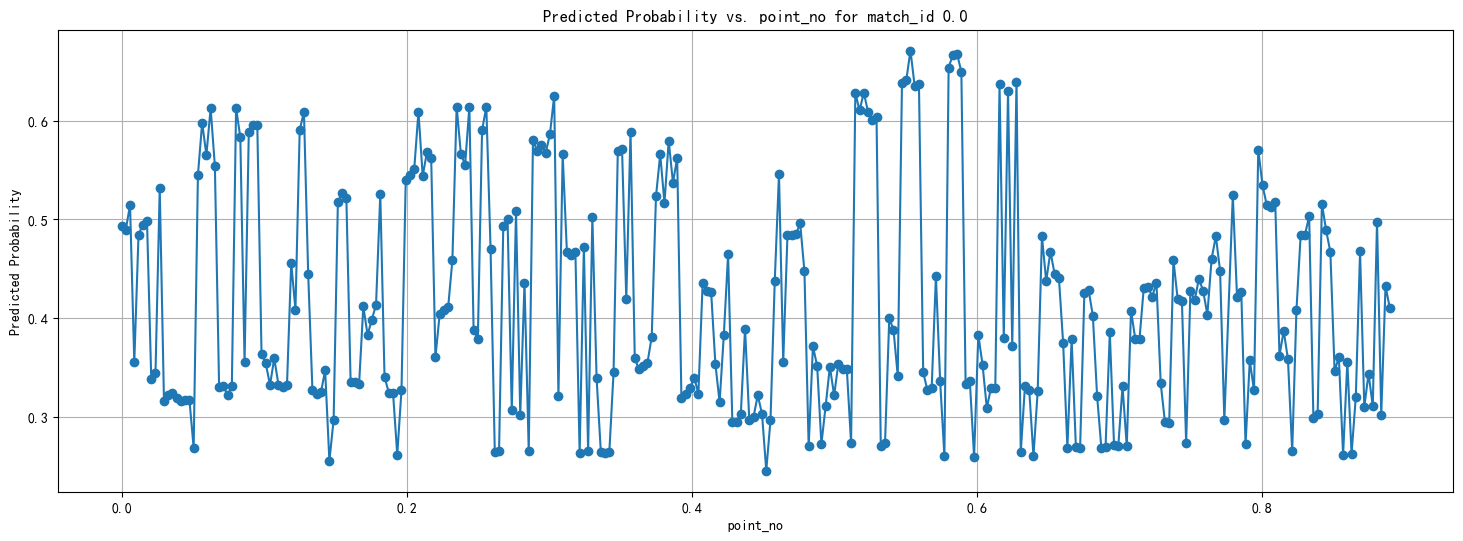

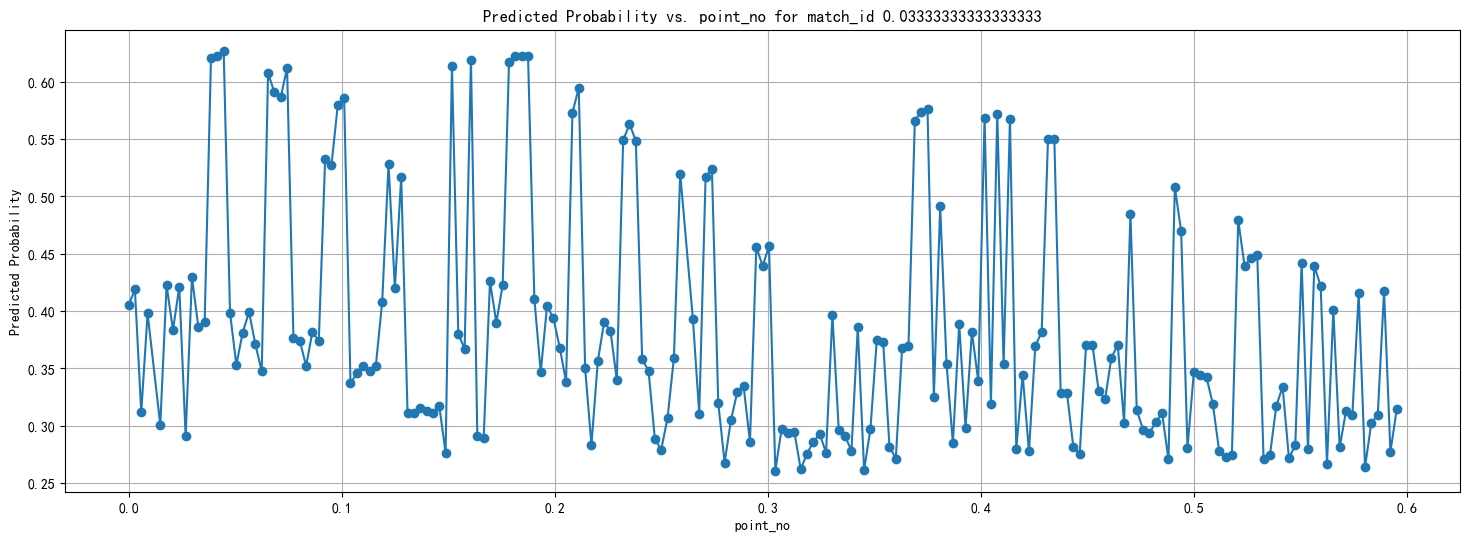

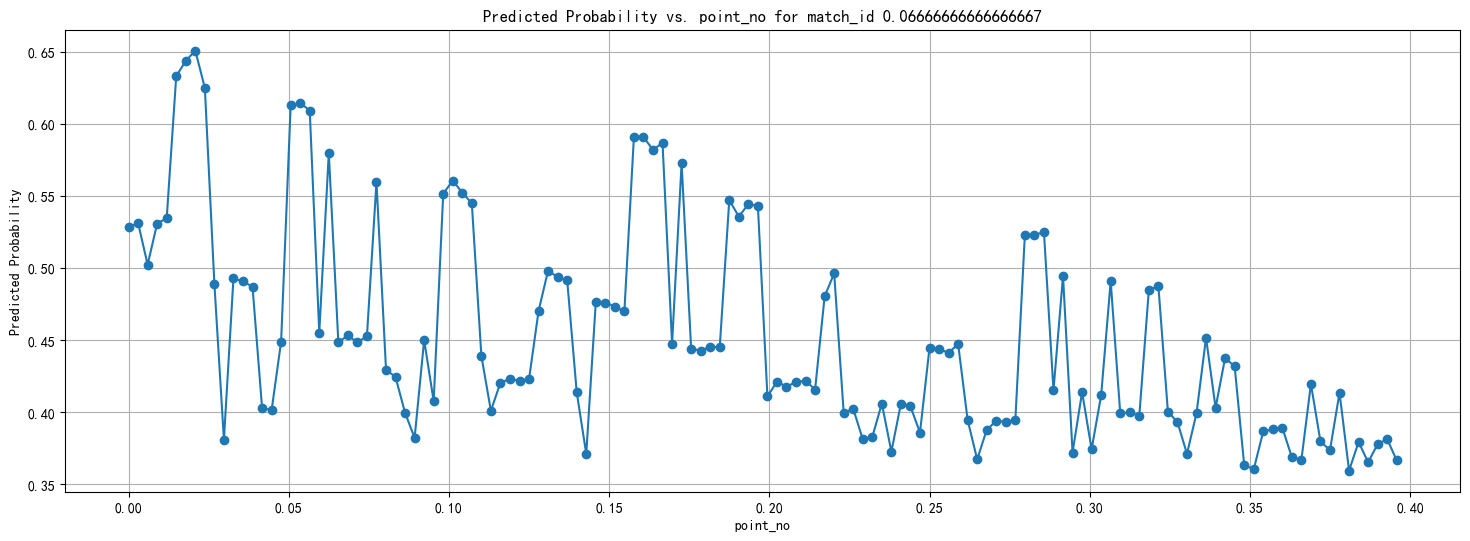

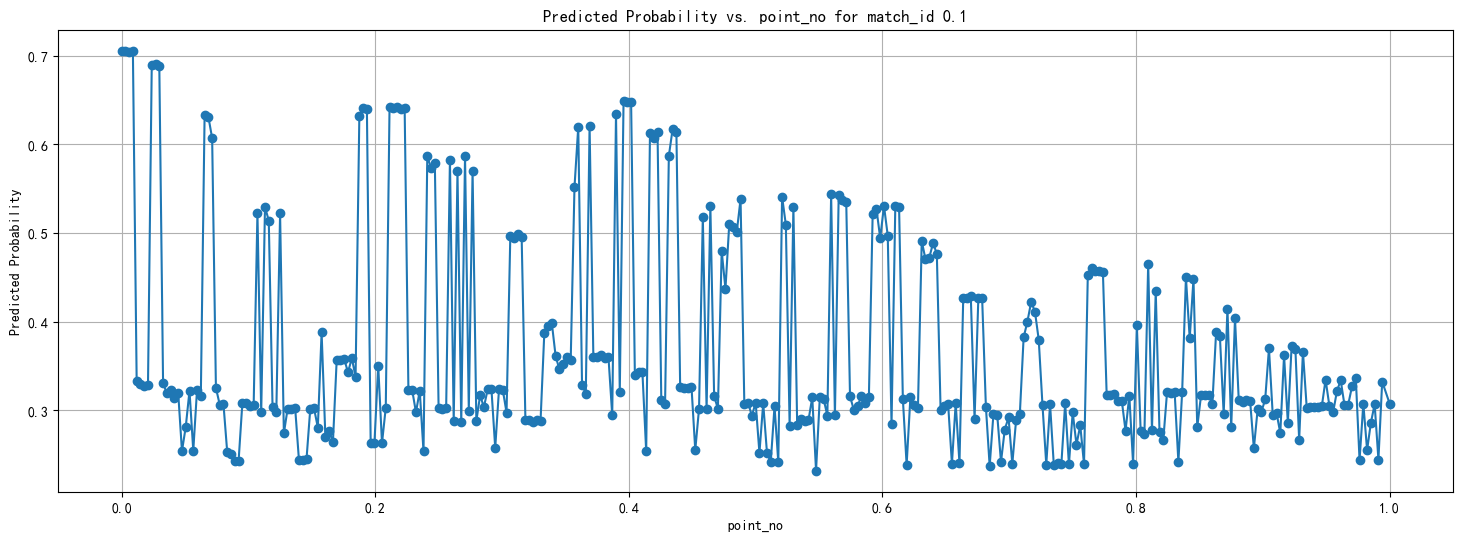

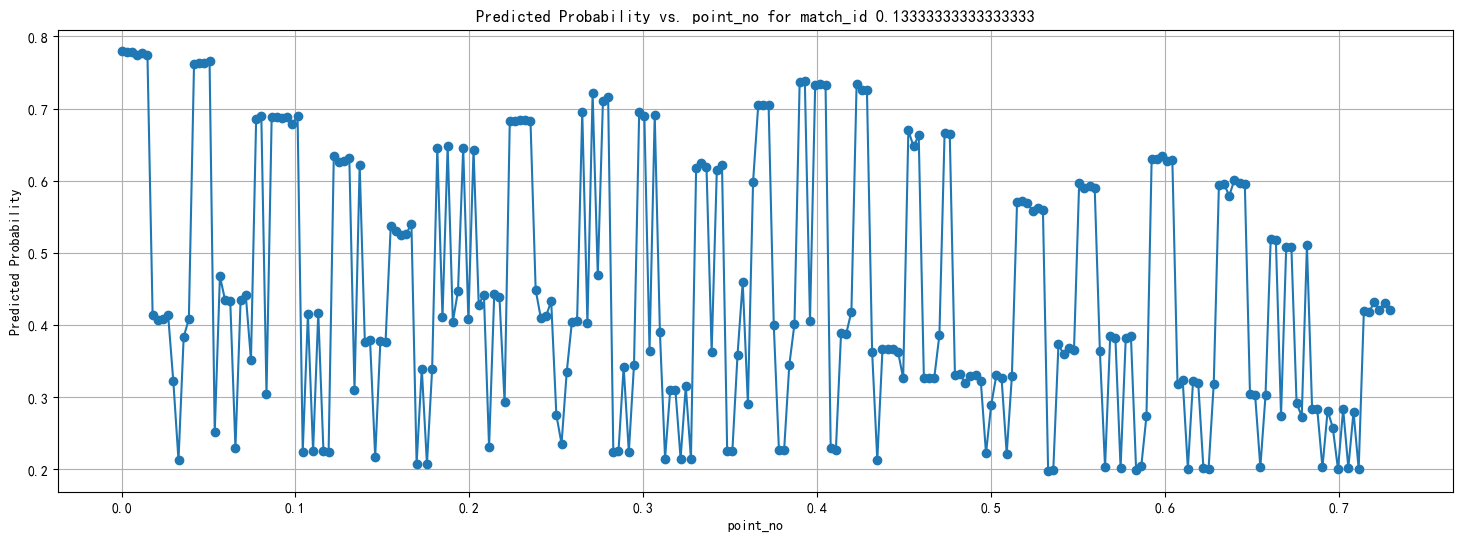

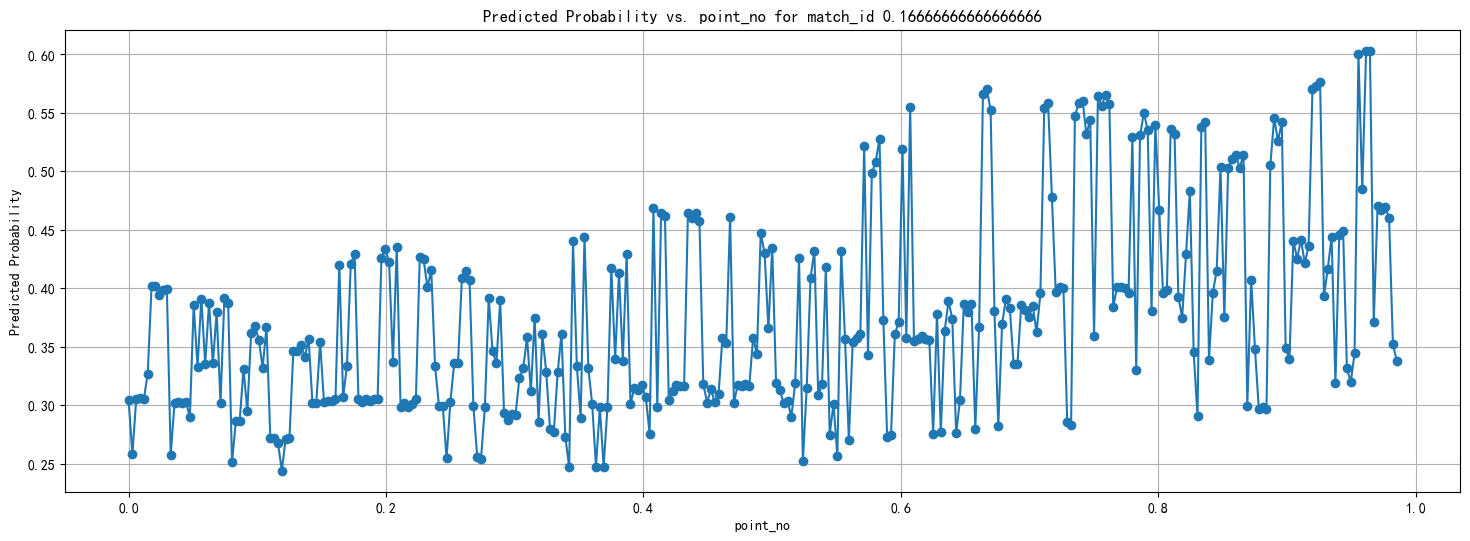

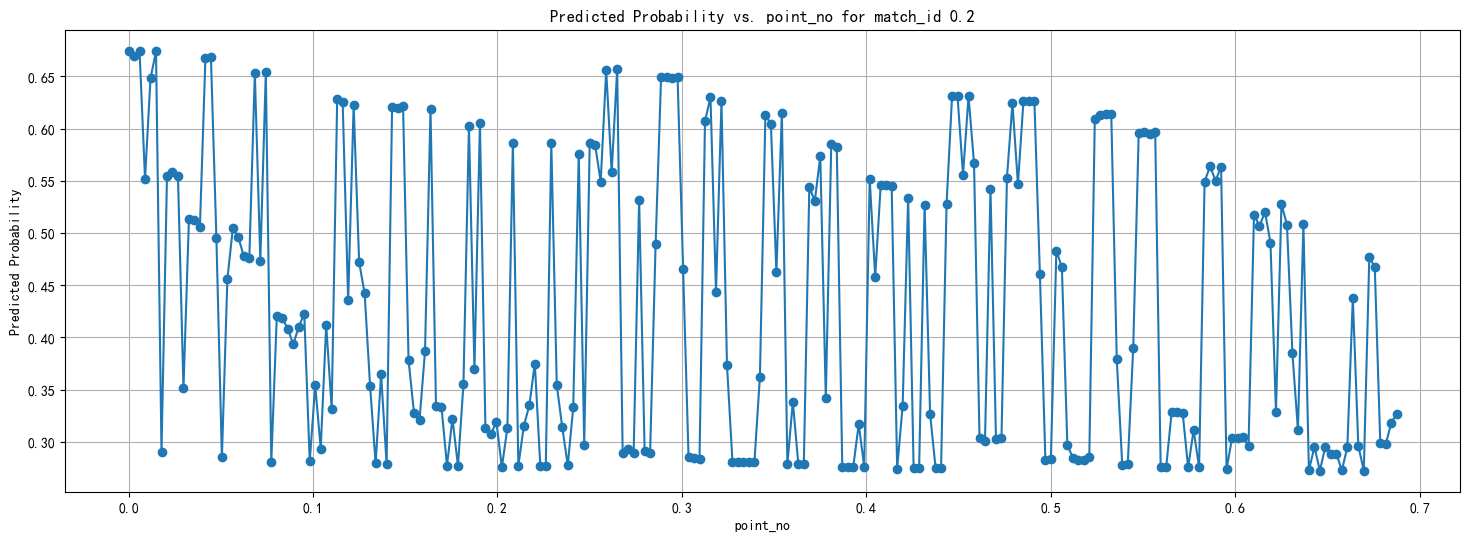

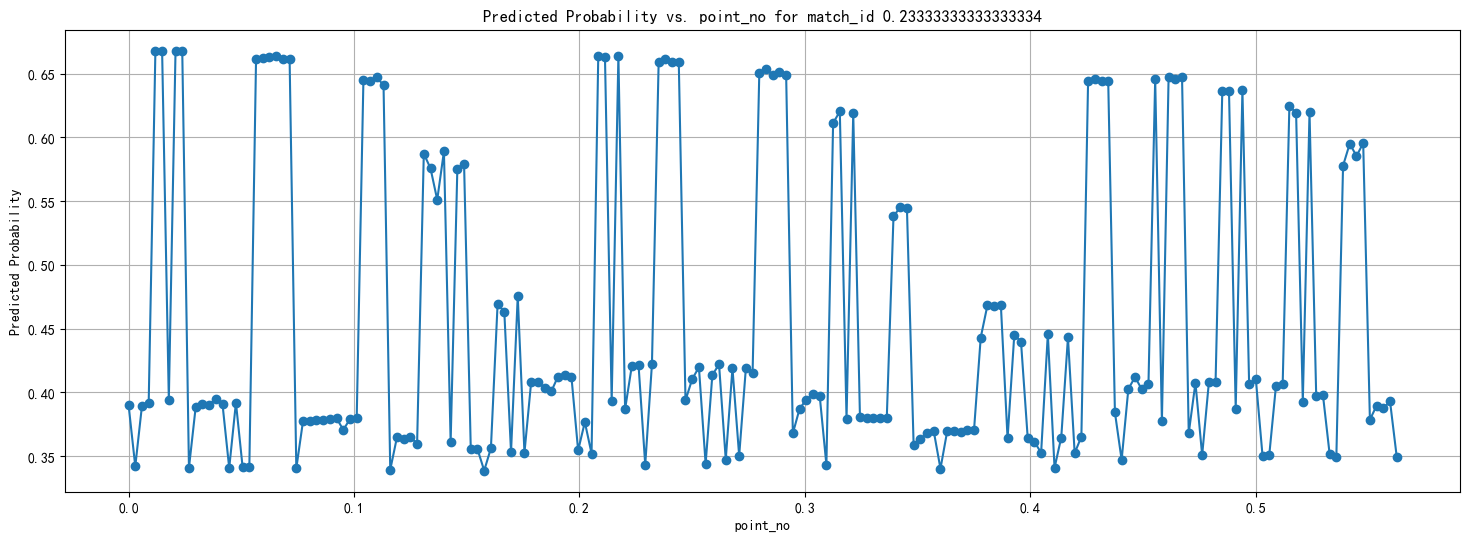

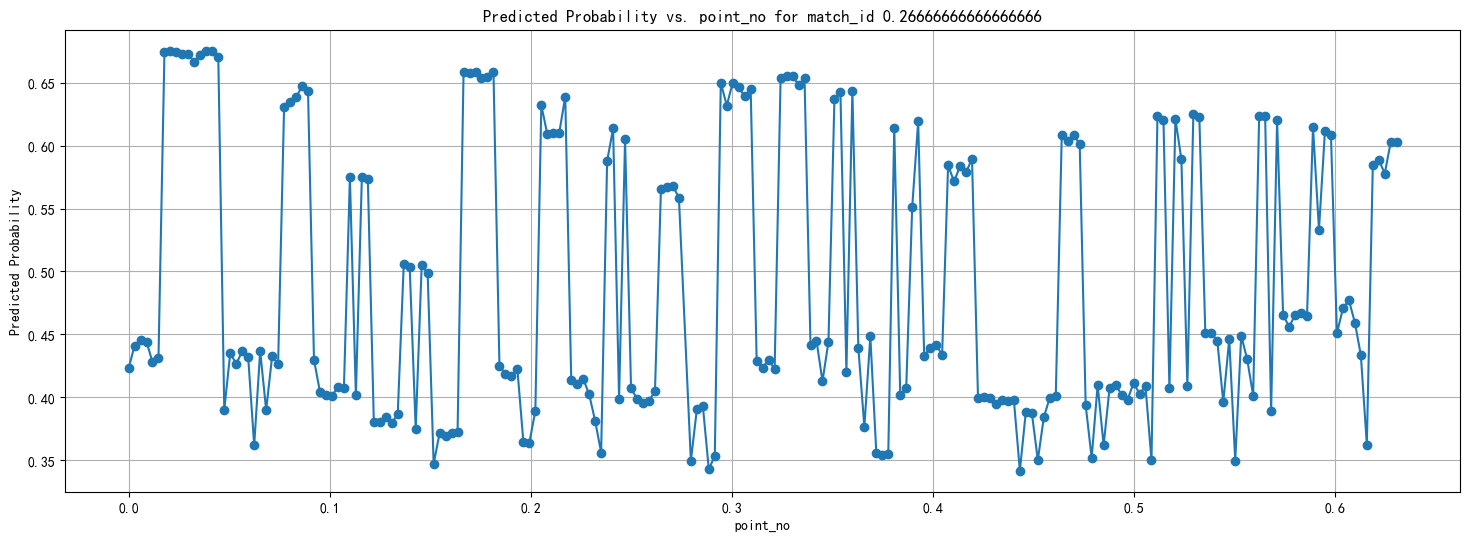

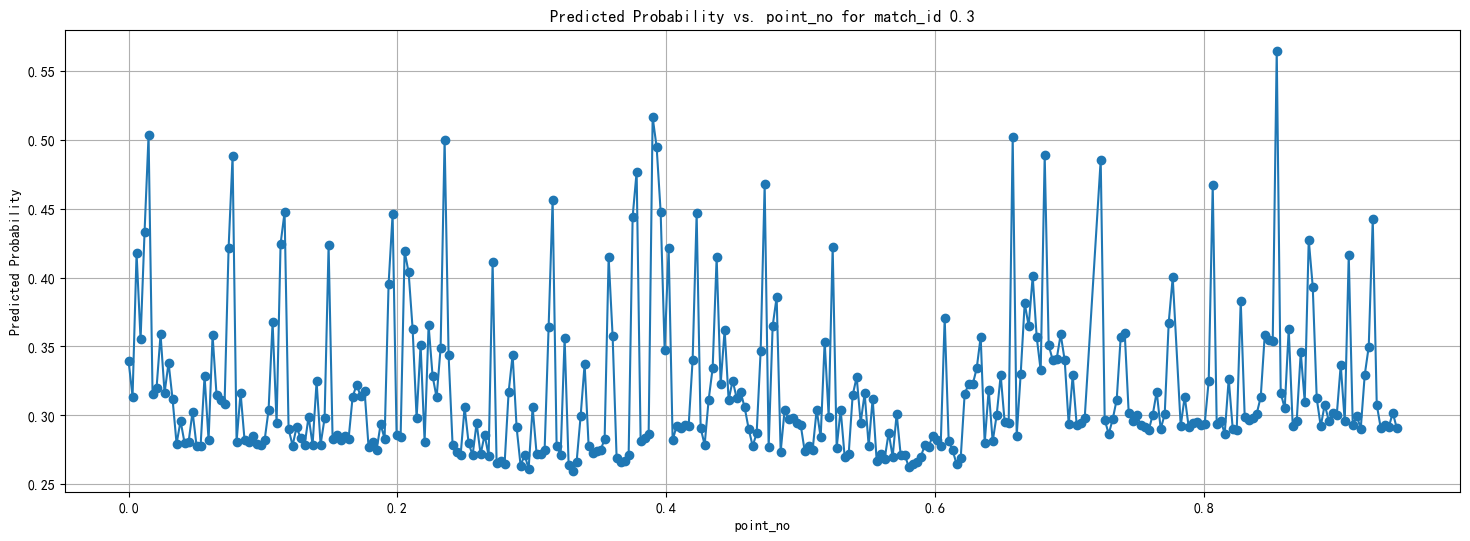

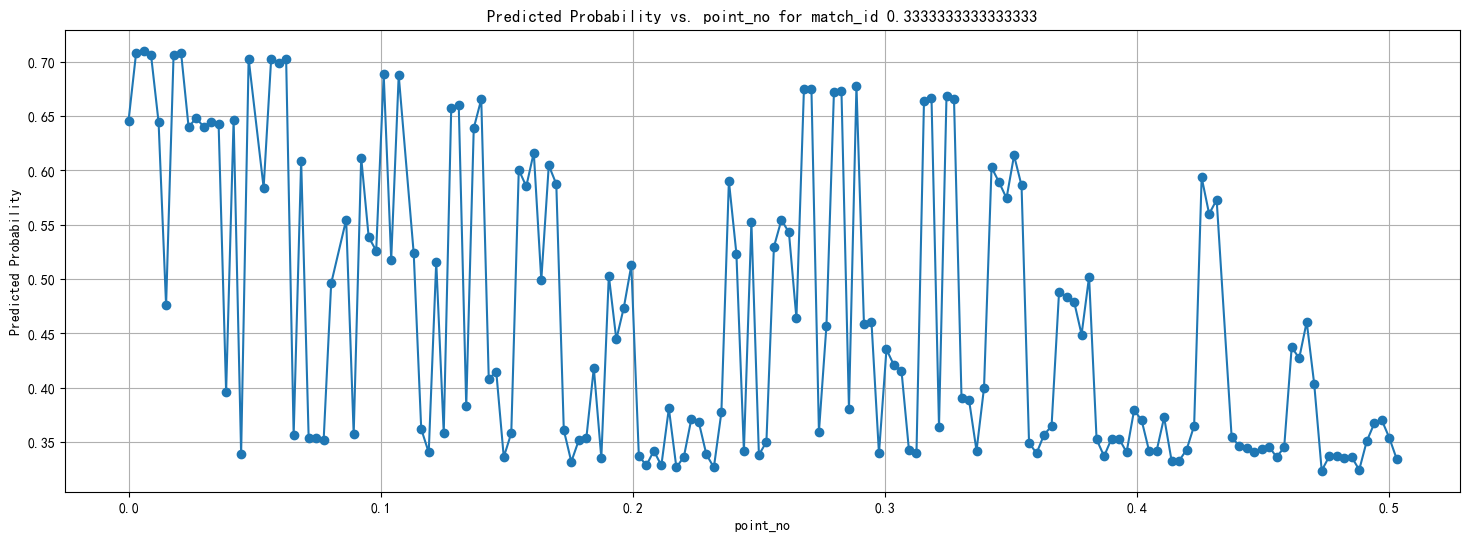

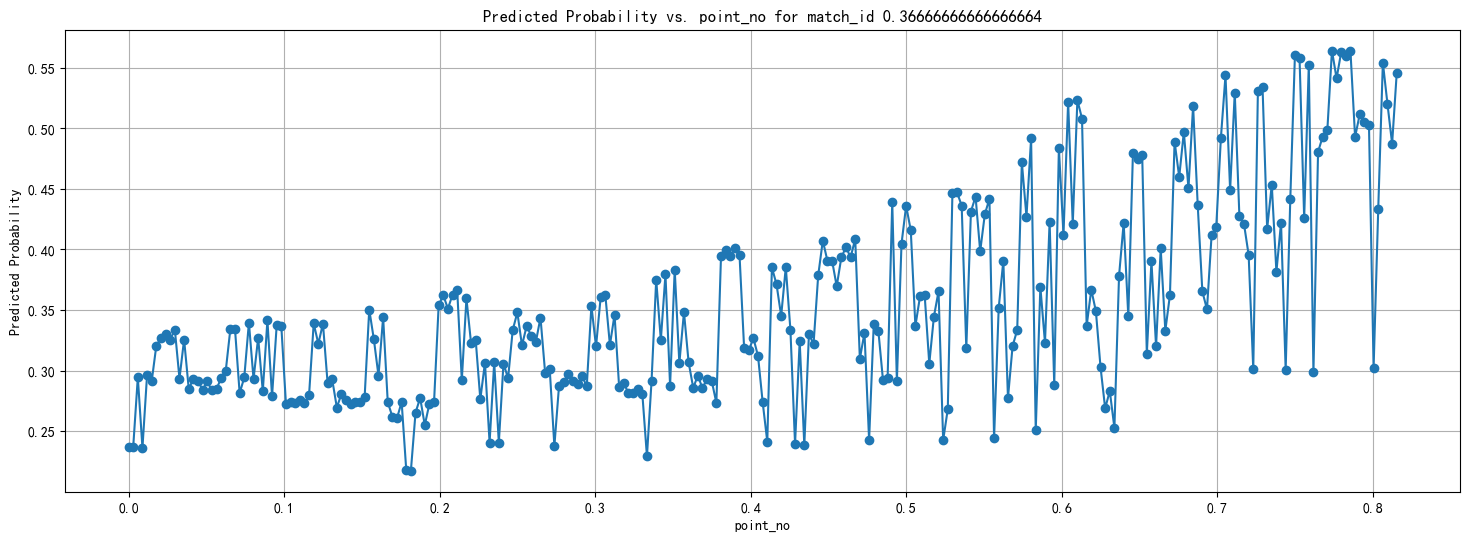

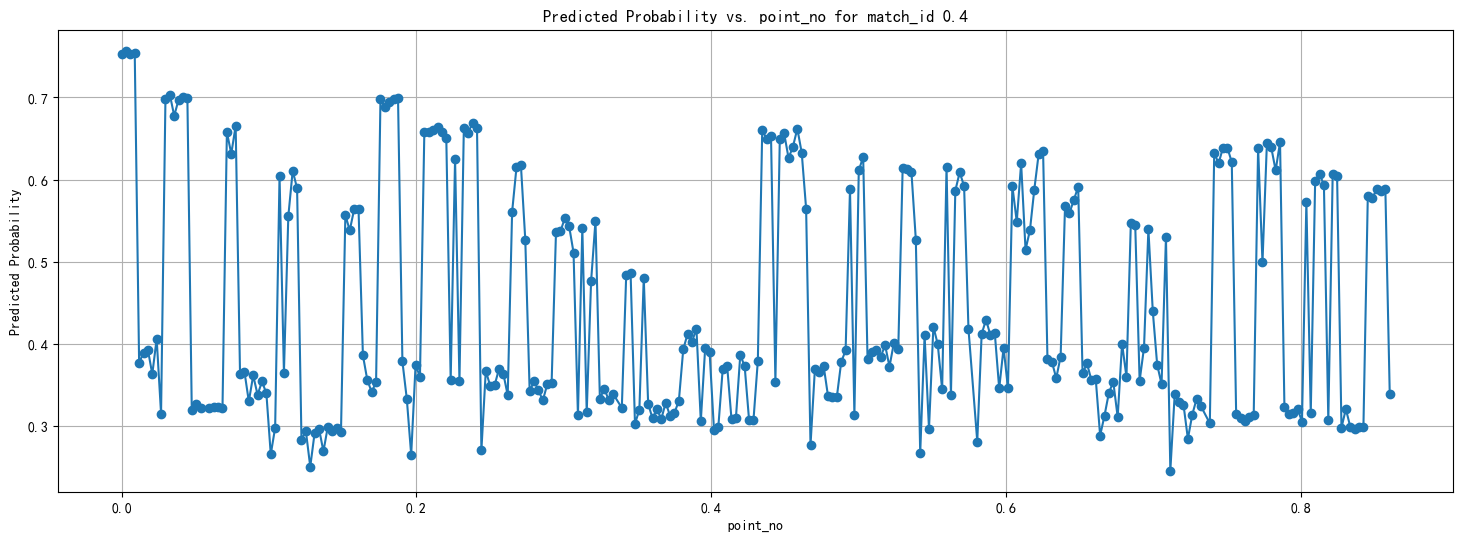

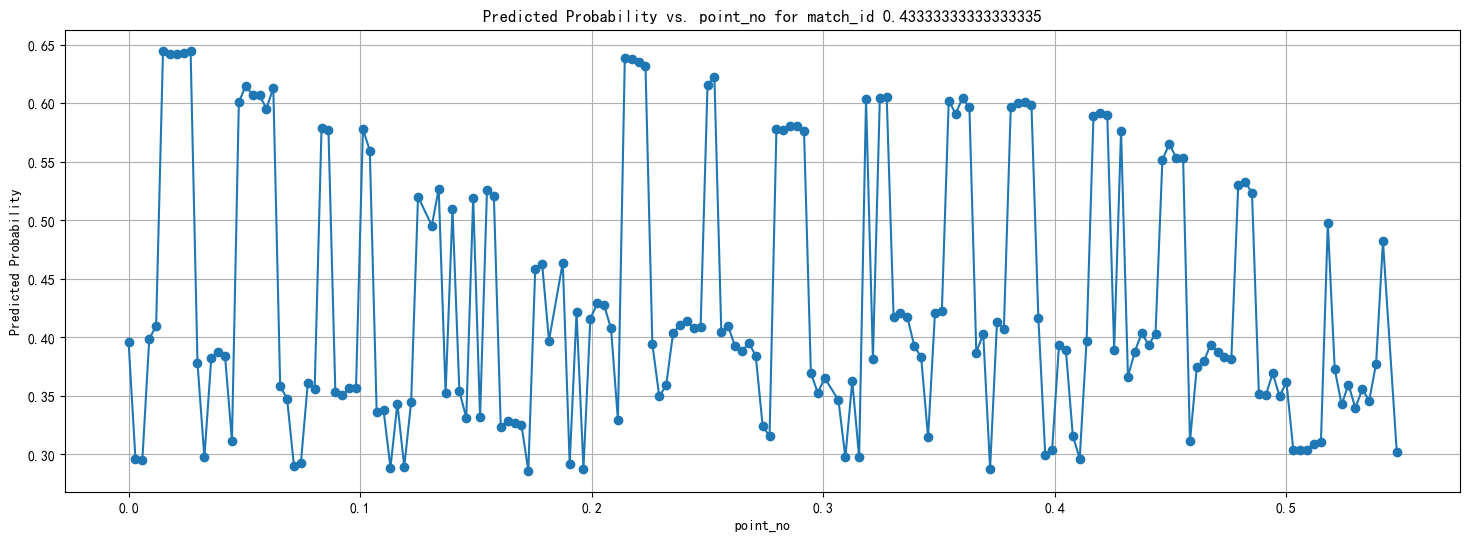

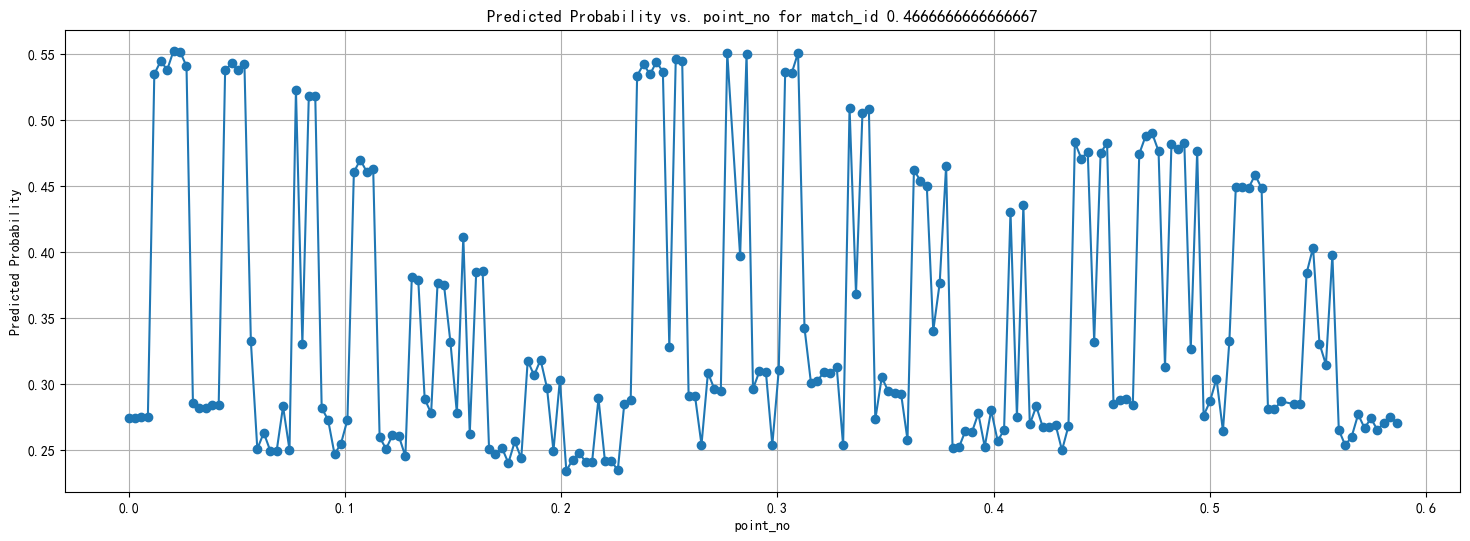

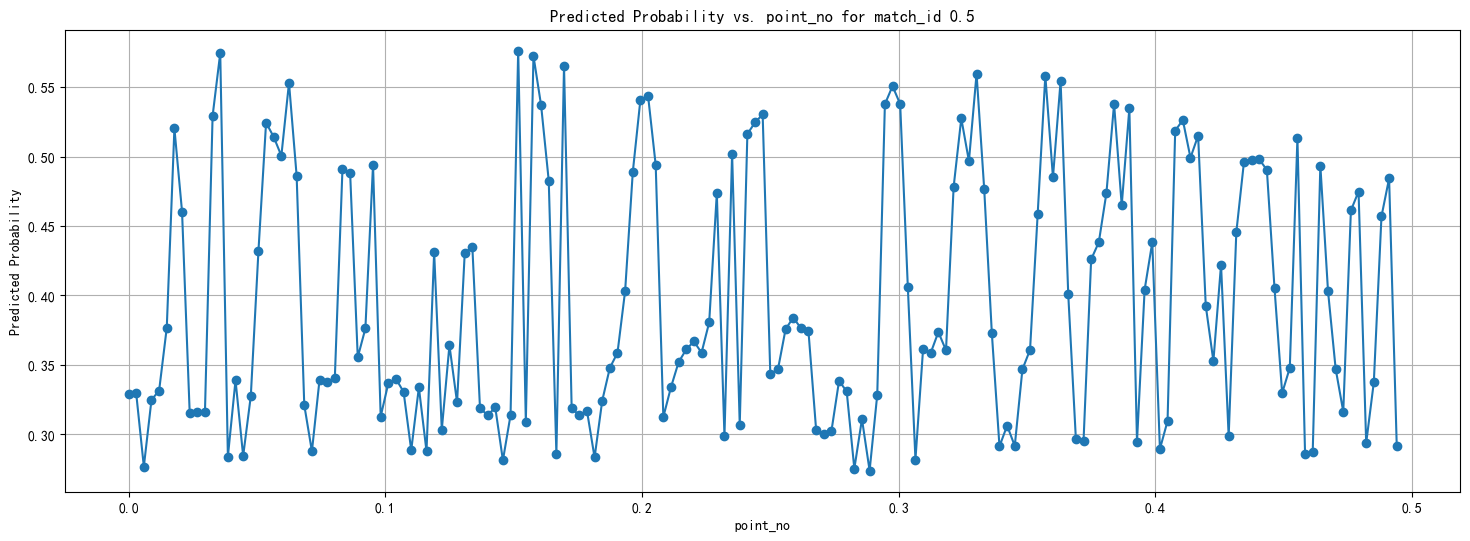

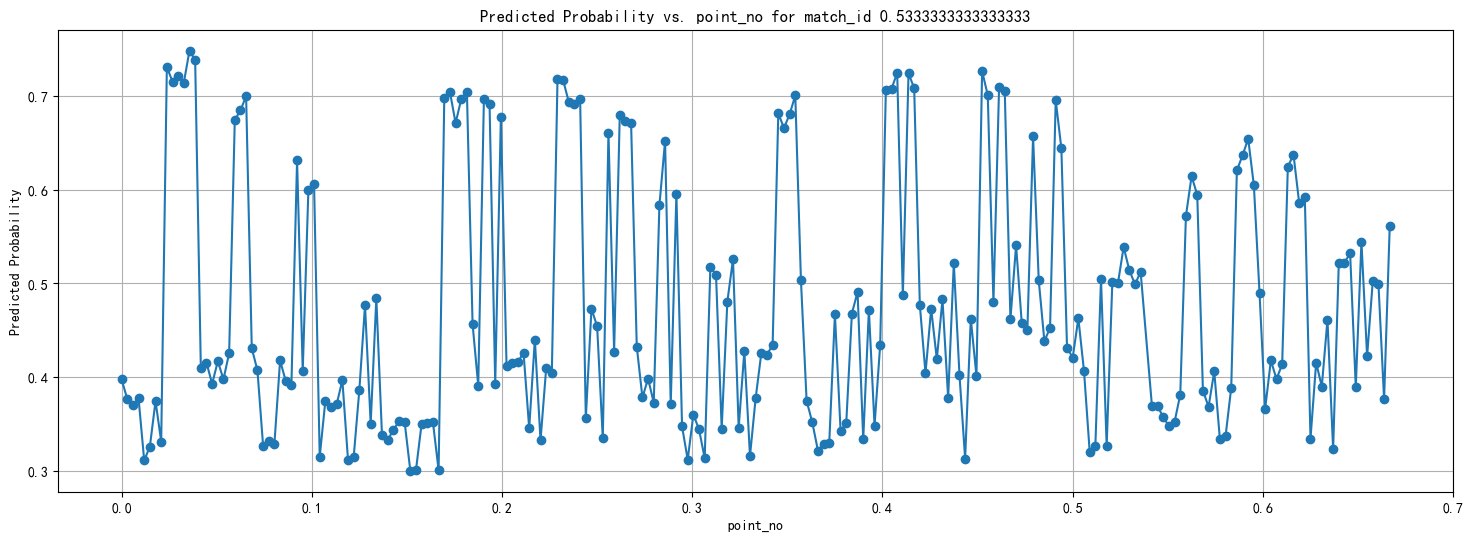

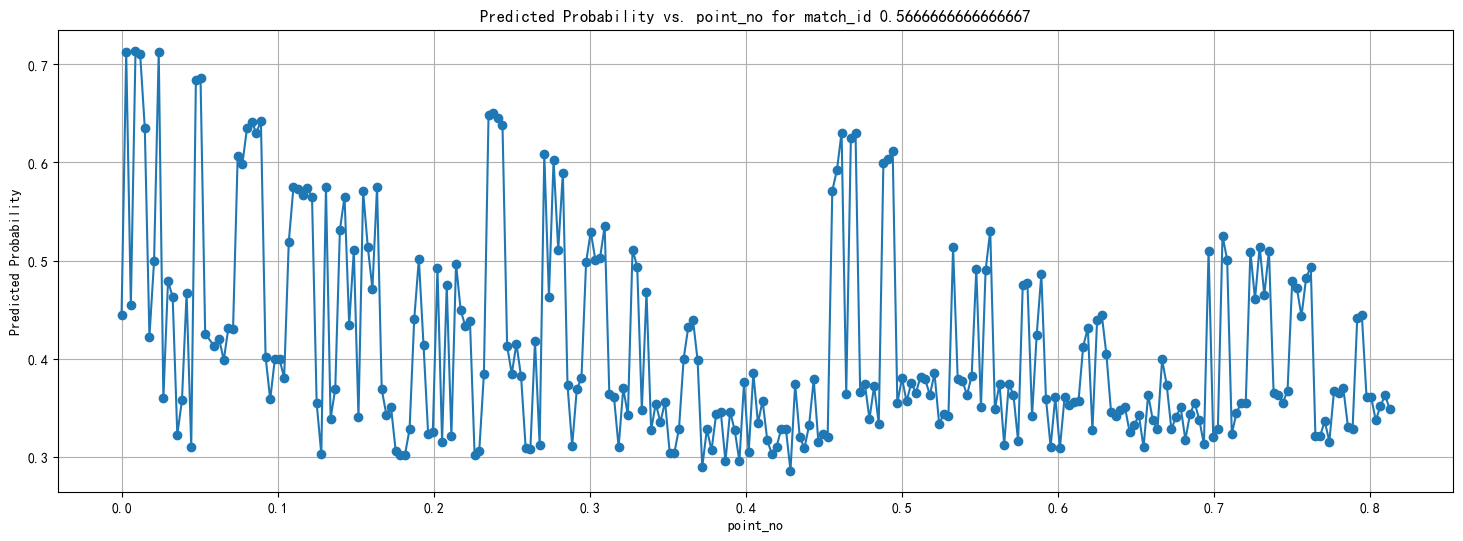

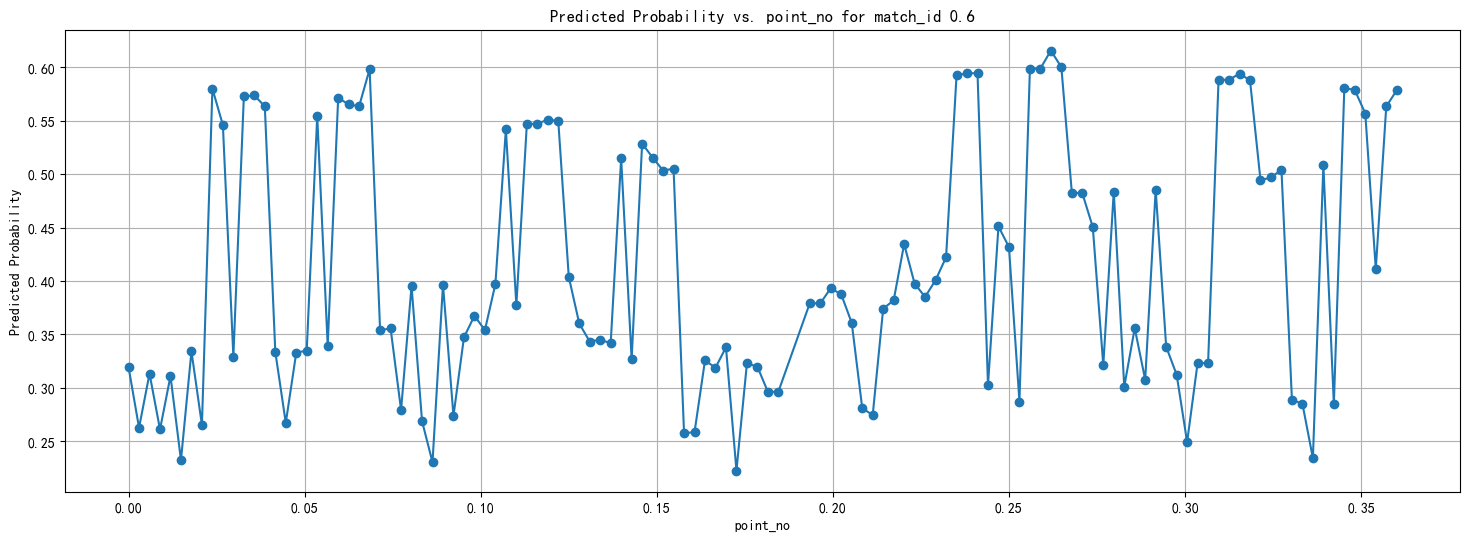

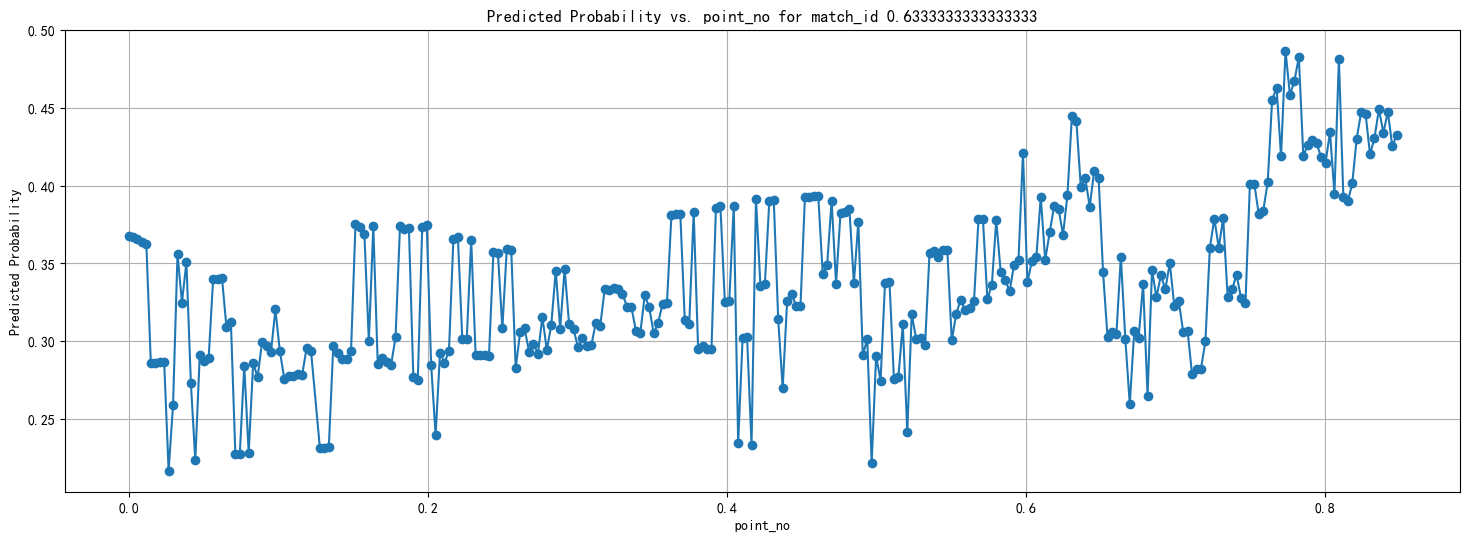

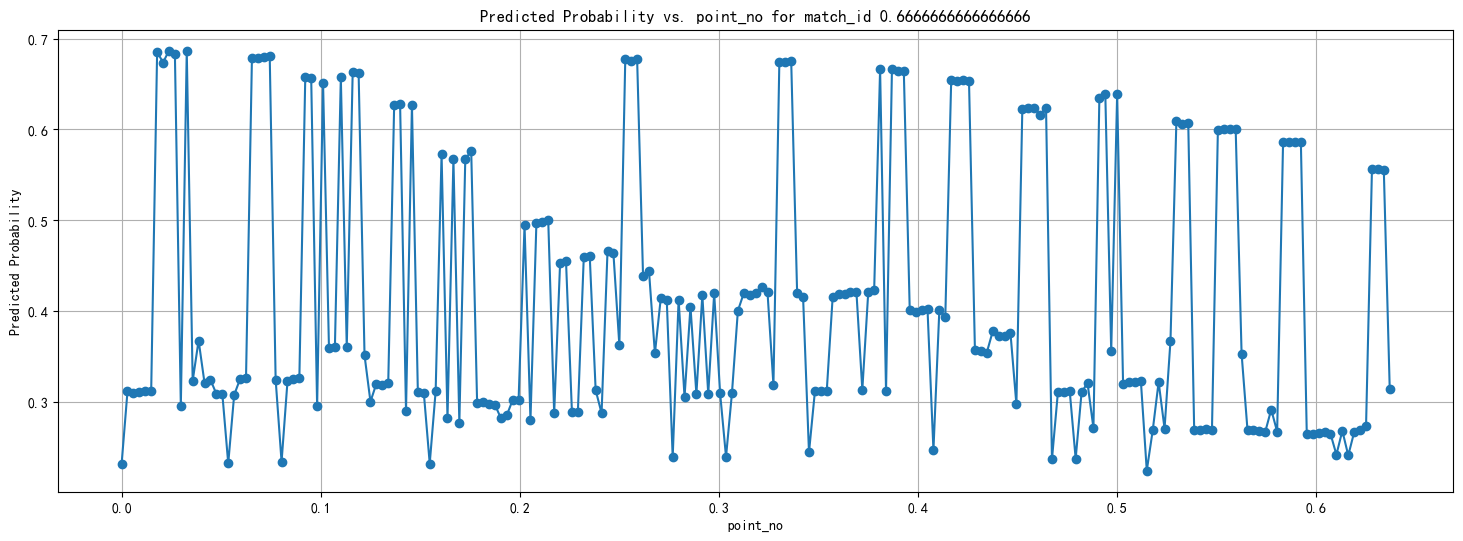

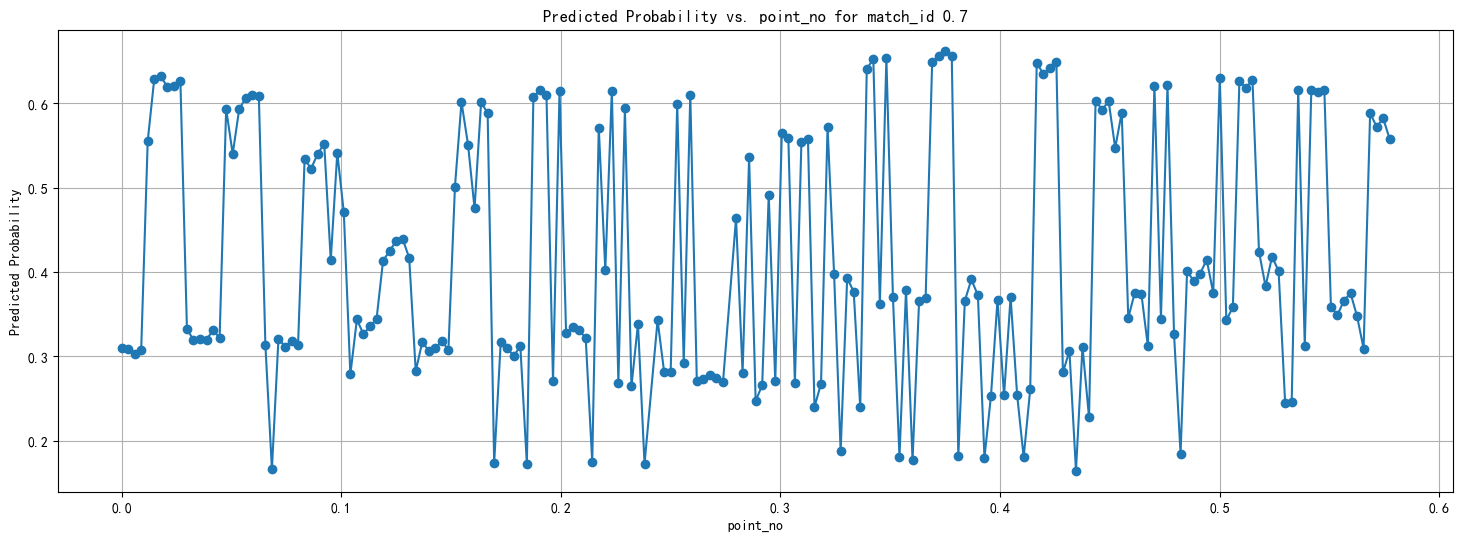

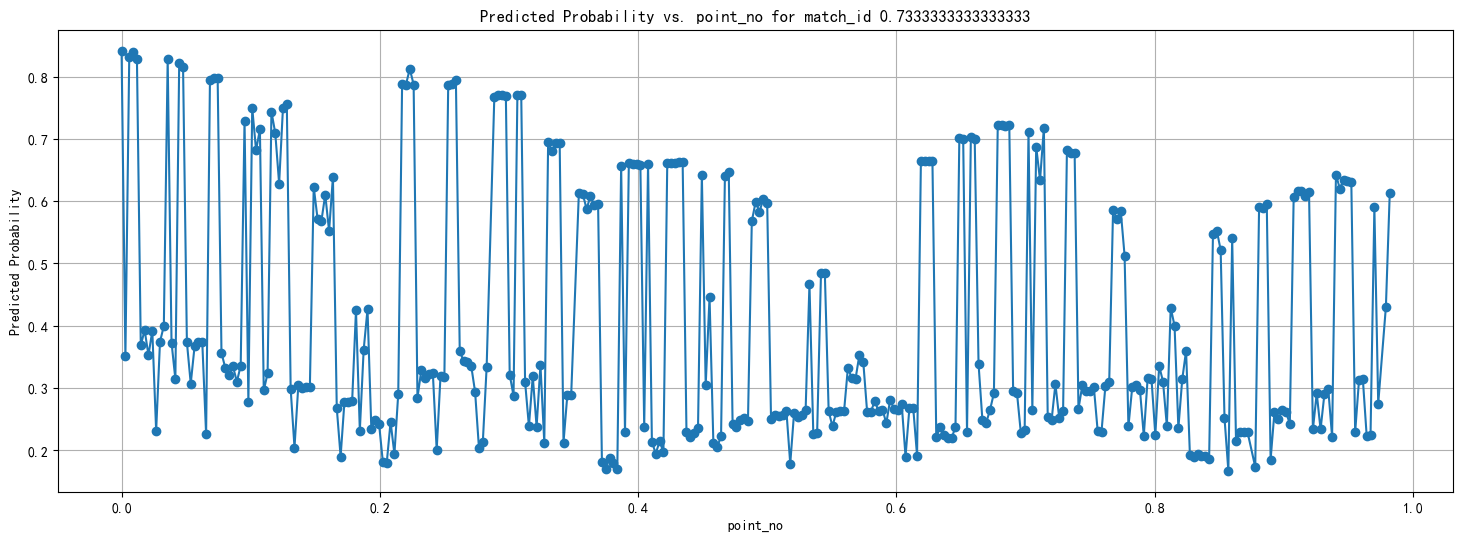

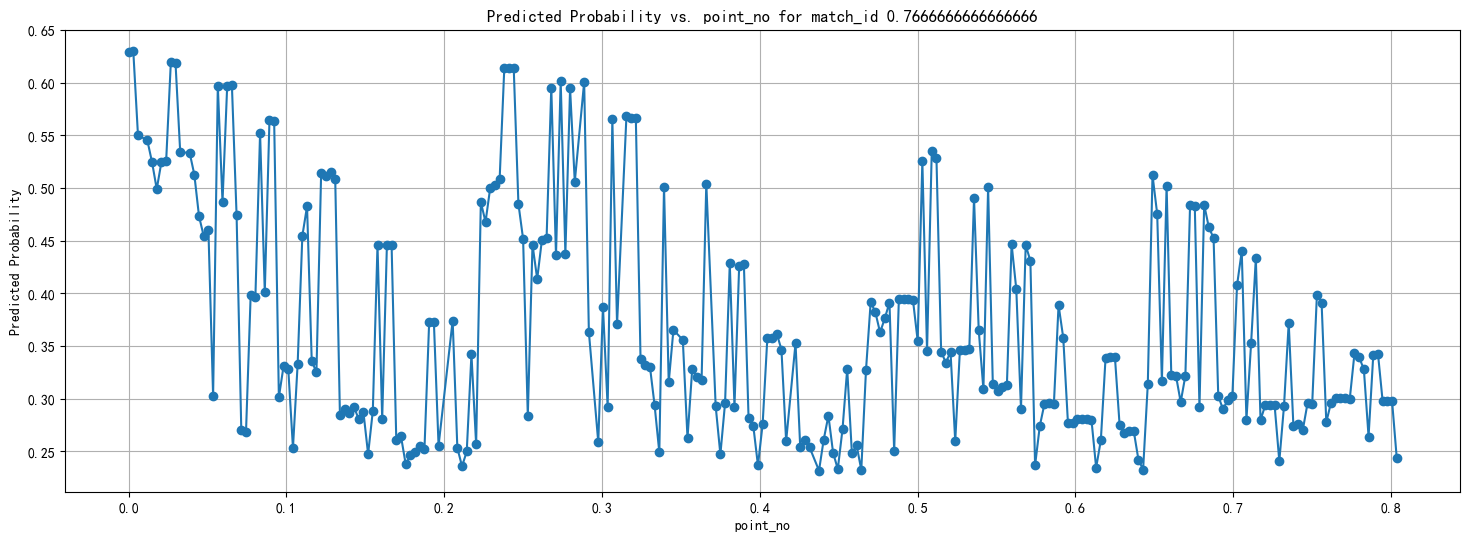

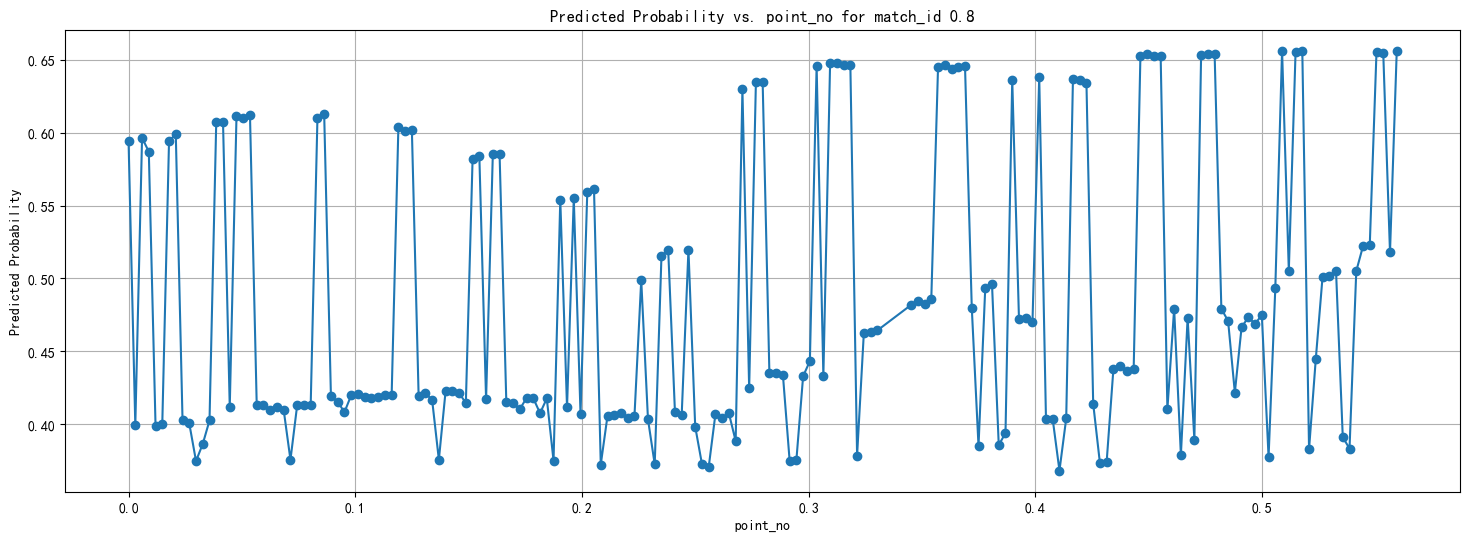

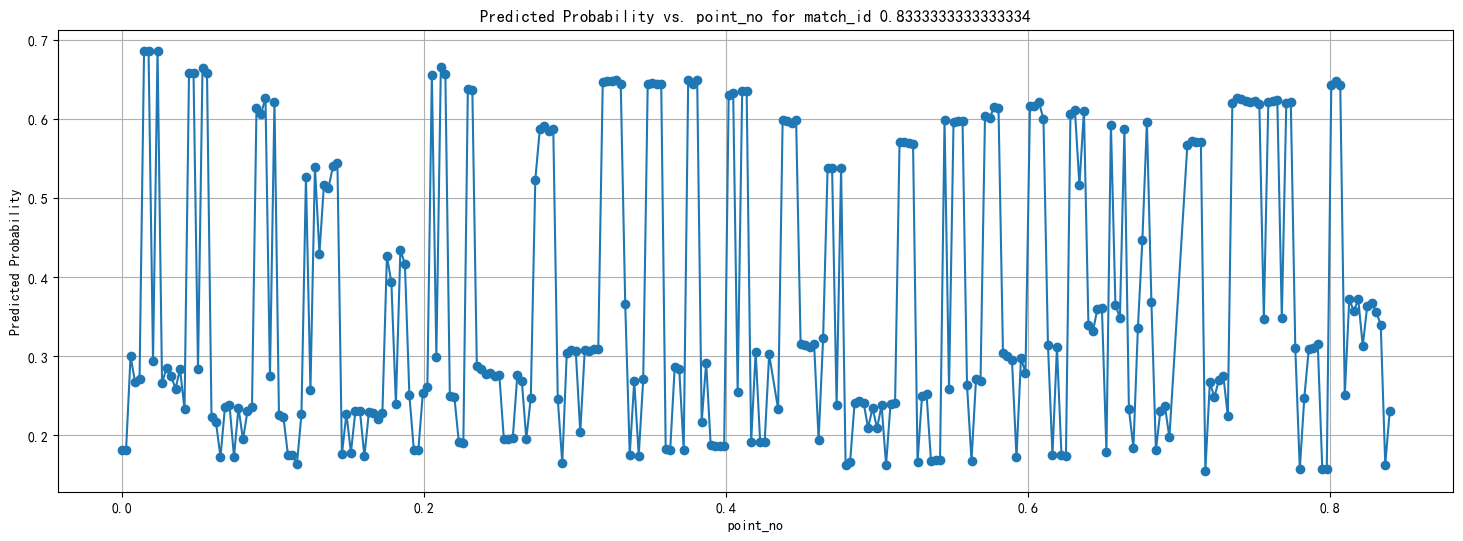

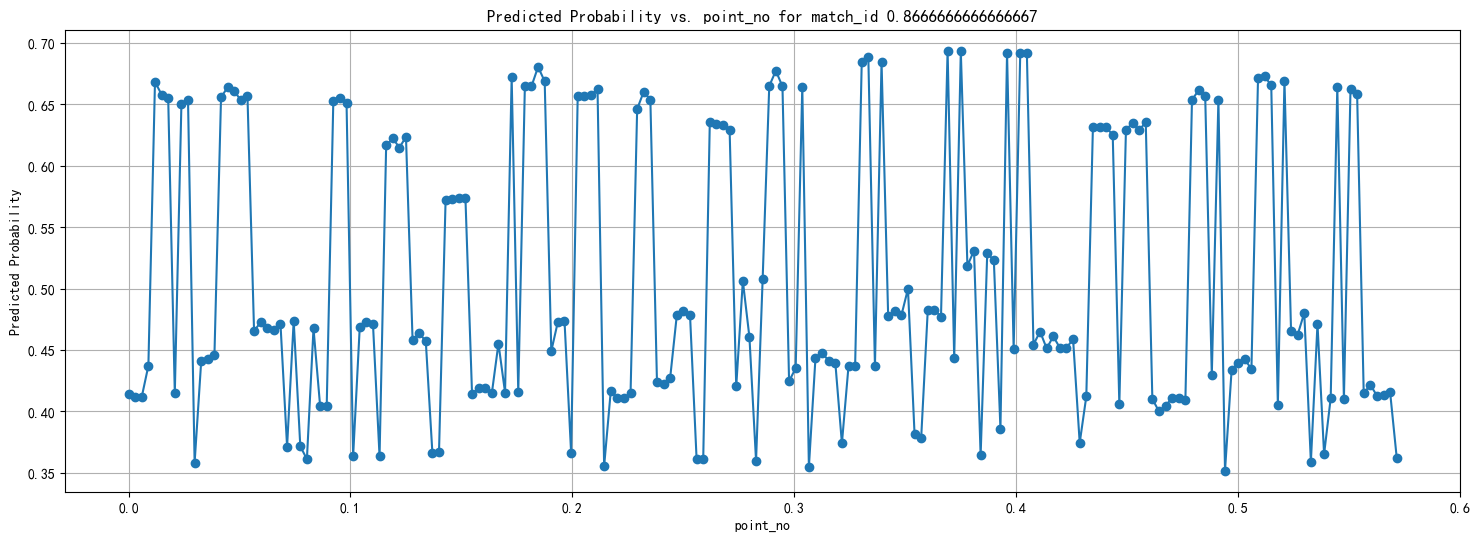

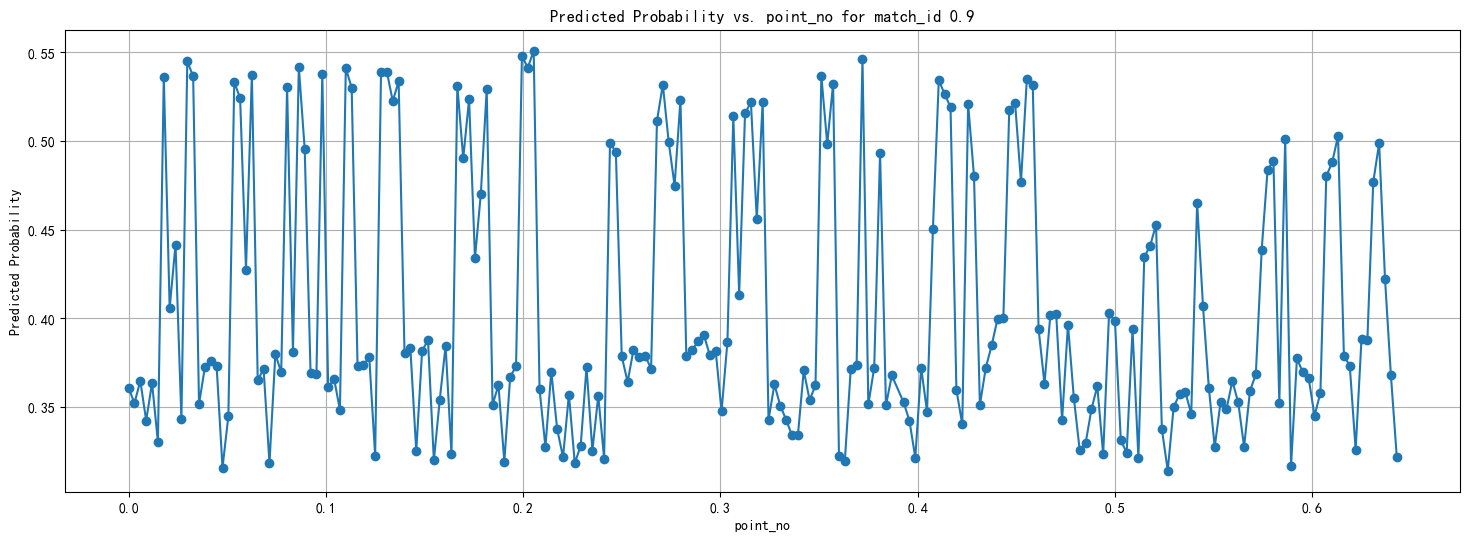

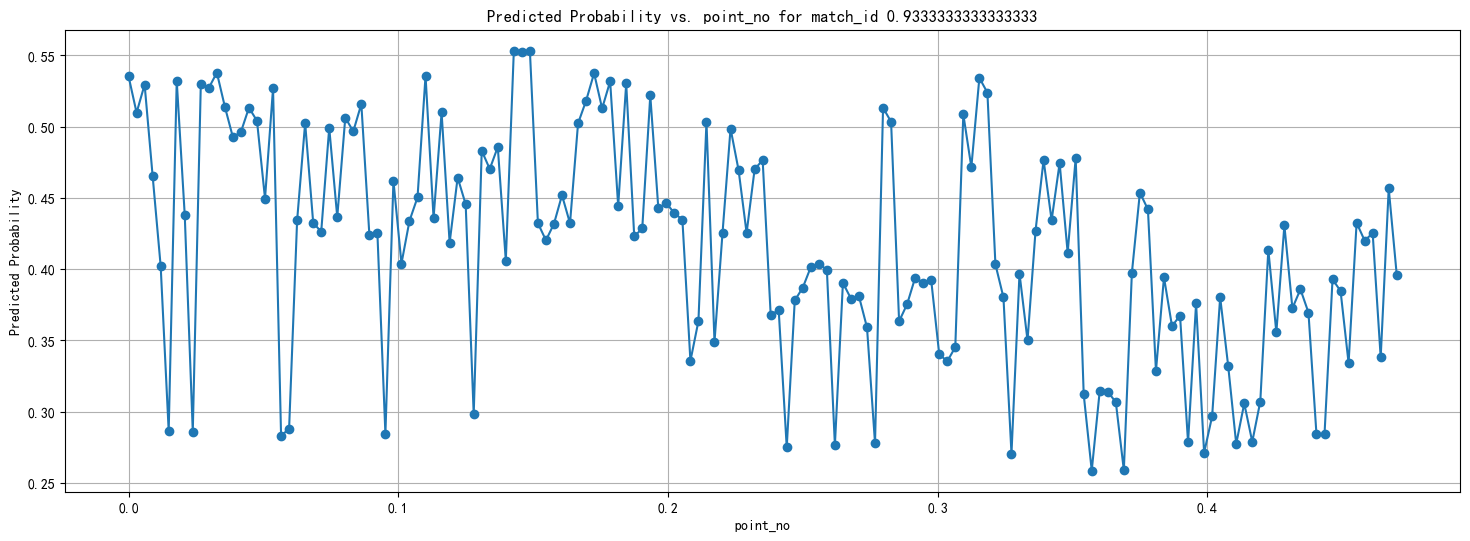

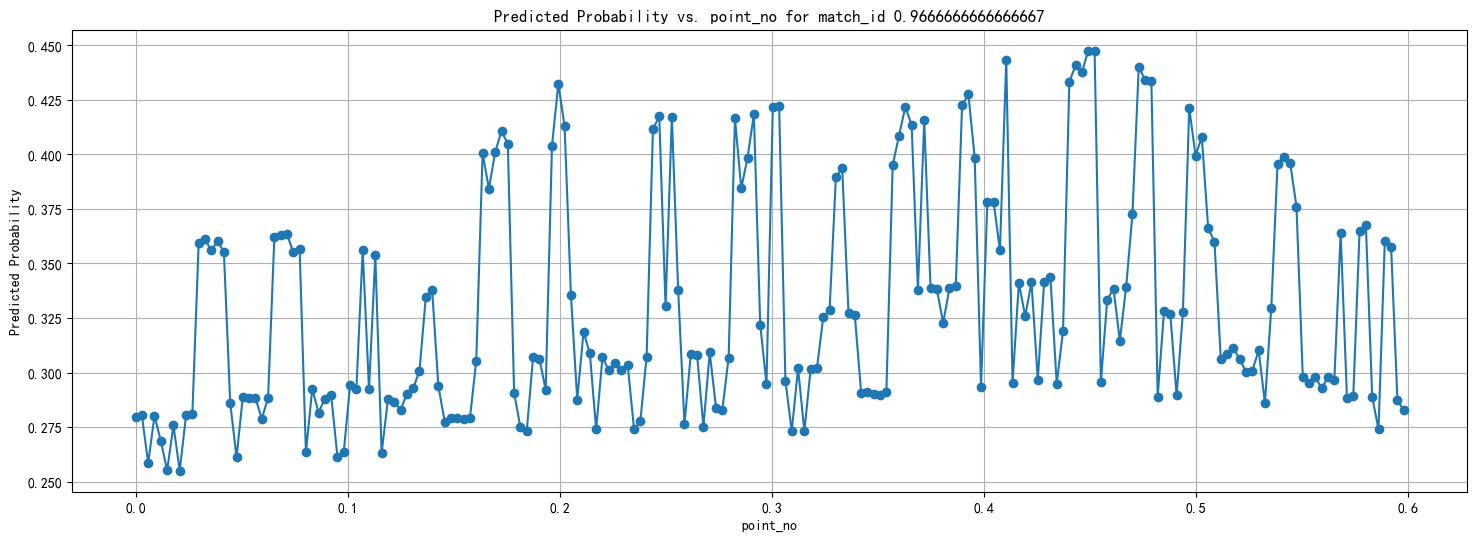

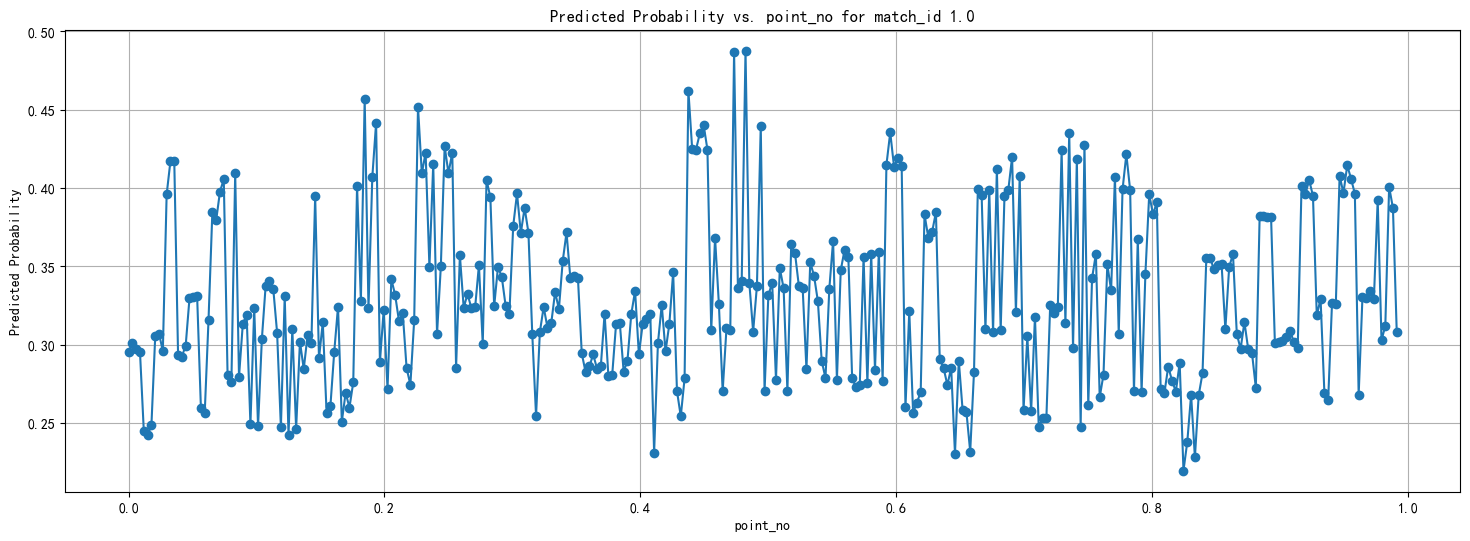

In [9]:
# 遍历每个不同的match_id
for match_id, group_data in grouped_data:
    # 创建子集数据
    subset_df = group_data.copy()
    subset_df['point_no'] = subset_df['point_no'].astype(float)
    
    # 创建折线图
    plt.figure(figsize=(18, 6))
    plt.plot(subset_df['point_no'], subset_df['final_pred'], marker='o', linestyle='-')
    plt.xlabel('point_no')
    plt.ylabel('Predicted Probability')
    plt.title(f'Predicted Probability vs. point_no for match_id {match_id}')
    plt.grid(True)
    
    # 显示或保存图形
    plt.show()  # 或者 plt.savefig('match_id_{}.png'.format(match_id)) 用于保存图形


# subset_df = df.iloc[1483:1502]

# # 创建折线图
# plt.figure(figsize=(12, 6))
# plt.plot(subset_df['point_no'], subset_df['predicted_probability'], marker='o', linestyle='-')
# plt.xlabel('point_no')
# plt.ylabel('Predicted Probability')
# plt.title('Predicted Probability vs. point_no')
# plt.grid(True)
# plt.show()